In [1]:
from sympy.combinatorics import Permutation, PermutationGroup
import numpy as np
import math
import sympy
import sympy.functions.combinatorial.numbers as math_num
from scipy.stats import chisquare
from scipy.stats import chi2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm import tqdm


In [2]:
def conv(x, y):
    r = max(len(x) - 1, len(y) - 1)
    last_sum1 = 0
    last_sum2 = 0
    while ((last_sum1 < 5) | (last_sum2 < 5)) &  (r >= 0):
        if (r <= len(x) - 1):
            last_sum1 += x[r]
        if (r <= len(y) - 1):
            last_sum2 += y[r]
        r = r - 1
    r += 1
    new_x = [0 for i in range(r+1)]
    new_y = [0 for i in range(r+1)]
    for i in range(r):
        new_x[i] = x[i]
        new_y[i] = y[i]
    new_x[r] = last_sum1   
    new_y[r] = last_sum2
    # new_x, new_y = np.trim_zeros(new_x), np.trim_zeros(new_y)
    while 0 in new_x: new_x.remove(0)
    while 0 in new_y: new_y.remove(0)
    #while(new_y[0] == 0):
    #    new_y = new_y[1:]
    return (new_x, new_y)

In [3]:
def chi(O, E):
    print(O)
    print(E)
    O,E = conv(O, E)
    l = len(O)
    while 0 in O: O.remove(0)
    while 0 in E: E.remove(0)
    print(O)
    print(E)
    r = 0
    for i in range(len(O)):
        r += (O[i] - E[i])**2/E[i]
    return (r, l)

## Permutation

In [21]:
n = 5  # длина подстановки
N = 2 ** 12 # размер выборки подстановок

num_of_cycles = [0 for k in range(n+1)]
num_of_fixed_points = [0 for k in range(n+1)]
num_shortest_cycle = [0 for k in range(n+1)]

a = Permutation(np.random.permutation(n))
print(a)
print(min(a.cycle_structure.keys()))

for i in range(N):
    a = Permutation(np.random.permutation(n))
    cycle_num = a.cycles
    num_of_cycles[a.cycles] += 1
    if 1 in a.cycle_structure.keys():
        num_of_fixed_points[a.cycle_structure[1]]  += 1
    else:
        num_of_fixed_points[0] += 1
    num_shortest_cycle[min(a.cycle_structure.keys())] += 1 
    
print(num_of_cycles)
print(num_of_fixed_points)
print(num_shortest_cycle)
print(a.list())
print(a.inversions())
print(a.is_even)
print(a.cycle_structure.keys().mean()) # средняя длина циклов


(4)(0 1)(2 3)
1
[0, 802, 1779, 1128, 356, 31]
[1512, 1568, 629, 356, 0, 31]
[0, 2584, 710, 0, 0, 802]
[3, 4, 1, 0, 2]
7
False


## Comparison of statistical distributions

In [5]:
# Неподвижные точки
E_prob_of_fixed_points = [((1 / math.factorial(k)) * (sympy.subfactorial(n - k) / math.factorial(n - k))) for k in range(n+1)]
E_num_of_fixed_points = [ x*N  for x in E_prob_of_fixed_points]
(num_of_fixed_points_stat, points_array_len) = chi(num_of_fixed_points, E_num_of_fixed_points)

# print(E_num_of_fixed_points)

points_quantile = chi2.ppf(1-0.05, df=points_array_len-1)
p_value = chi2.sf(float(num_of_fixed_points_stat), int(points_array_len-1))

print("Квантиль степени " + str(points_array_len - 1) + " = " + str(points_quantile))
print("Статистика для k неподвижных точек = " + str(num_of_fixed_points_stat))
print("p-value = " + str(p_value))

[1475, 1520, 748, 258, 81, 14, 0, 0, 0, 0, 0]
[1506.8342857142857, 1506.8331569664904, 753.4222222222222, 251.12380952380954, 62.81481481481482, 12.515555555555554, 2.1333333333333333, 0.27089947089947086, 0.050793650793650794, 0, 0.00112874779541446]
[1475, 1520, 748, 258, 81, 14]
[1506.8342857142857, 1506.8331569664904, 753.4222222222222, 251.12380952380954, 62.81481481481482, 14.9717107583774]
Квантиль степени 5 = 11.070497693516351
Статистика для k неподвижных точек = 6.34267144665169
p-value = 0.2742885837339039


In [6]:
# Длины циклов
E_prob_of_cycles = [((1 / math.factorial(n)) * math_num.stirling(n, k, kind=1)) for k in range(len(num_of_cycles))]
E_num_of_cycles = [ x*N  for x in E_prob_of_cycles]
(num_of_cycle_stat, cycle_array_len) = chi(num_of_cycles, E_num_of_cycles)

#print(E_num_of_cycles)

cycle_quantile = chi2.ppf(1-0.05, df=cycle_array_len-1)
p_value = chi2.sf(float(num_of_cycle_stat), int(cycle_array_len-1))

print("Квантиль степени " + str(cycle_array_len - 1) + " = " + str(cycle_quantile))
print("Статистика для ровно k циклов = " + str(num_of_cycle_stat))
print("p-value = " + str(p_value))

[0, 412, 1172, 1292, 827, 307, 73, 13, 0, 0, 0]
[0, 409.600000000000, 1158.74539682540, 1323.68253968254, 816.852204585538, 304.000000000000, 71.4192592592592, 10.6666666666667, 0.982010582010582, 0.0507936507936508, 0.00112874779541446]
[412, 1172, 1292, 827, 307, 73, 13]
[409.600000000000, 1158.74539682540, 1323.68253968254, 816.852204585538, 304.000000000000, 71.4192592592592, 11.7005996472663]
Квантиль степени 6 = 12.591587243743977
Статистика для ровно k циклов = 1.25896756174401
p-value = 0.9738720085933817


In [7]:
# Кратчайший цикл имеет длину k

def expindex(x, M):
    res = x
    for i in range(2, M + 1):
        res += (x**i) / i
    return -res

def nthcoeff(f, x, n):
    res = sympy.diff(f, x, n)
    return res.subs(x, 0) / math.factorial(n)

def get_polynom_for_cycle_length(M, n): 
    x = sympy.Symbol('x')
    f = 1 - sympy.exp(-x) if  M == 0 else sympy.exp(expindex(x, M)) - sympy.exp(expindex(x, M + 1))
    return nthcoeff(f / (1 - x), x, n)

def gen_prob_of_shortest_cycles(n):
    t = time.perf_counter()
    short_cycle_length_exp = [0] * n
    for i in tqdm(range(math.floor(n / 2) + 1)):
        short_cycle_length_exp[i] = get_polynom_for_cycle_length(i, n) 
    short_cycle_length_exp[n-1] = get_polynom_for_cycle_length(n-1, n)
    exp = np.array(np.array([float(i) for i in short_cycle_length_exp]))
    # exp = np.trim_zeros(np.sort(exp))
    return exp

def gen_prob_of_shortest_cycles2(n):
    exp = [0] * n
    for i in range(1, math.floor(n / 2)):
        exp[i] = math.exp(-sympy.harmonic(i)) - math.exp(-sympy.harmonic(i+1))
    exp[0] = 1 - math.exp(-1)
    exp[n-1] = 1 / n
    return exp


In [8]:
# Кратчайший цикл имеет длину k

E_prob_of_shortest_cycle = gen_prob_of_shortest_cycles(n)
E_num_of_shortest_cycle = [ x*N  for x in E_prob_of_shortest_cycle]

num_shortest_cycle = gen_prob_of_shortest_cycles2(n)
num_shortest_cycle = [ x*N  for x in num_shortest_cycle]

(shortest_cycle_stat, shortest_cycle_array_len) = chi(num_shortest_cycle, E_num_of_shortest_cycle)

shortest_cycle_quantile = chi2.ppf(1-0.05, df=shortest_cycle_array_len-1)
p_value = chi2.sf(float(shortest_cycle_stat), int(shortest_cycle_array_len-1))

print("Квантиль степени " + str(shortest_cycle_array_len - 1) + " = " + str(shortest_cycle_quantile))
print("Статистика для минимального цикла длины k = " + str(shortest_cycle_stat))
print("p-value = " + str(p_value))

100%|█████████████████████████████████████████████| 6/6 [01:34<00:00, 15.72s/it]


[2589.165808961772, 592.8930550702593, 259.0736960255423, 144.8561649072986, 92.44935974735574, 0, 0, 0, 0, 409.6]
[2589.1657142857143, 592.7111111111111, 251.93650793650792, 170.66666666666666, 81.92, 0.0, 0.0, 0.0, 0.0, 409.6]
[2589.165808961772, 592.8930550702593, 259.0736960255423, 144.8561649072986, 92.44935974735574, 409.6]
[2589.1657142857143, 592.7111111111111, 251.93650793650792, 170.66666666666666, 81.92, 409.6]
Квантиль степени 5 = 11.070497693516351
Статистика для минимального цикла длины k = 5.459019666288368
p-value = 0.36246045159685264


## Show distributions

In [ ]:

(inf, coef) = compare_formulas(n, n)
x = np.array([i for i in range(1, len(coef) + 1)])
plt.scatter(x, inf, c='b', marker='x', label='Limit of \"n\" to infinity', alpha=0.5)
plt.plot(x, inf, c='b', alpha=0.4)
plt.scatter(x, coef, c='r', marker='s', label='Got \"n\" from coefficients', alpha=0.5)
plt.plot(x, coef, c='r', alpha=0.4)
plt.legend(loc='center')
plt.xlabel('Minimal cycle lengths', fontsize=10, labelpad=18)
plt.ylabel('Probability', fontsize=10, labelpad=18)
plt.title('Probabilities for the minimum cycle lengths (n = {})'.format(n), fontsize=14)
plt.grid()
plt.show()


## Correlation table

In [9]:
def count_records(permutation: Permutation): 
    maximum = -1
    records = 0 
    for index, elem in enumerate(permutation.list()): 
         if elem > maximum: 
            records += 1
            maximum = elem    
    return records

In [39]:
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())

In [71]:
# correlation table

corr_df = pd.DataFrame(columns=['n','N','FP & SC', 'FP & Rec', 'FP & NoC', 'FP & Ord', 'FP & Inv', 'FP & Evn',
                                'SC & Noc', 'SC & Rec', 'SC & Ord', 'SC & Inv', 'SC & Evn', 'Rec & NoC',
                                'Rec & Ord', 'Rec & Inv', 'Rec & Evn', 'Noc & Ord', 'Noc & Inv', 'Noc & Evn',
                                'Ord & Inv', 'Ord & Evn', 'Inv & Evn'])

# длина подстановки n
# длина выборки N
n_N_values = [(10, 2**10), (10, 2**12), (10, 2**14), (10, 2**16), (10, 2**18),
              (25, 2**10), (25, 2**12), (25, 2**14), (25, 2**16), (25, 2**18),
              (50, 2**10), (50, 2**12), (50, 2**14), (50, 2**16), (50, 2**18),
              (100, 2**10), (100, 2**12), (100, 2**14), (100, 2**16), (100, 2**18),
              (200, 2**10), (200, 2**14), (200, 2**16), (200, 2**18),
              (500, 2**10), (500, 2**14), (500, 2**16), (500, 2**18),
              (1000, 2**10), (1000, 2**14), (1000, 2**16), 
             ]

t1 = time.perf_counter()
# n_N_values[1:2]
for p in [(10, 2**10)]:
    
    n, N = p
    t2 = time.perf_counter()
    
    # 'Fixed points','Shortest cycle','Records', 'Number of cycles', 'Order', 'Inversions', 'Even'
    df = pd.DataFrame(columns=['FP','SC','Rec', 'NoC', 'Ord', 'Inv', 'Evn'])

    num_of_cycles = 0
    num_of_fixed_points = 0
    length_of_shortes_cycle = 0
    order = 1
    even = 0
    inversions = 0
    
    for i in tqdm(range(N)):
        a = Permutation(np.random.permutation(n))
        num_of_cycles = a.cycles
        if 1 in a.cycle_structure.keys():
            num_of_fixed_points = a.cycle_structure[1]
        else:
            num_of_fixed_points = 0
        length_of_shortes_cycle = min(a.cycle_structure.keys())
        num_of_records = count_records(a)
        order = 1
        for x in list(a.cycle_structure.keys()):
            order = np.lcm(order, x)
        even = a.is_even
        inversions = a.inversions()
        # avgl = [a.cycle_structure]
        df.loc[len(df)] = [num_of_fixed_points, length_of_shortes_cycle, num_of_records, num_of_cycles, order, inversions, even]        
            
    print("n="+ str(n), "N=" + str(N), " - Done," + " Time: " + str(round(time.perf_counter() - t1, 1)))
    df = df.astype({"Evn": int})
    for col in df.columns:
        df[col] = min_max_scaling(df[col])
    cm = df.corr()
    corr_df.loc[len(corr_df)] = [n, N, cm['FP']['SC'], cm['FP']['Rec'], cm['FP']['NoC'], cm['FP']['Ord'], cm['FP']['Inv'],
                                 cm['FP']['Evn'], cm['SC']['Rec'], cm['SC']['NoC'], cm['SC']['Ord'], cm['SC']['Inv'], cm['SC']['Evn'],
                                 cm['Rec']['NoC'], cm['Rec']['Ord'], cm['Rec']['Inv'], cm['Rec']['Evn'], cm['NoC']['Ord'],
                                 cm['NoC']['Inv'], cm['NoC']['Evn'], cm['Ord']['Inv'], cm['Ord']['Evn'], cm['Inv']['Evn']
                                ]


corr_df = corr_df.round(3)
corr_df = corr_df.astype({"n": int, "N": int})
df.to_csv("./df.csv", index=None)  
# df.to_csv("./df.csv", index=None, mode='a', header=None)  
corr_df.to_csv("./corr.csv", index=None)  
# corr_df.to_csv("./corr.csv", index=None, mode='a', header=None)  

100%|██████████████████████████████████████| 1024/1024 [00:01<00:00, 661.29it/s]

n=10 N=1024  - Done, Time: 1.6


<AxesSubplot:>

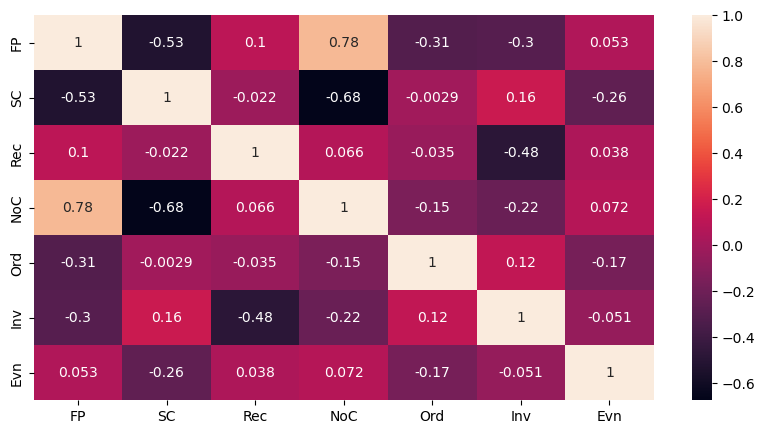

In [72]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True)

In [ ]:
print(df)